In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
# import seaborn as sns
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
# import arrow
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
# weekly_df = weekly_df.iloc[209:]
weekly_df.index = pd.DatetimeIndex(weekly_df.index)

train_mask = (weekly_df.index > "2006") & (weekly_df.index < "2011")
train = weekly_df[train_mask].cases
test_mask = (weekly_df.index > "2011")
test = weekly_df[test_mask].cases

In [3]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$Seasonal\,Part_{1} = \,s_{0}* \,\sin(\dfrac{\pi\,x}{52}) \, + \,s_{0}$$

$$Seasonal\,Part_{2} =\,\cos^2(k\,x +\, \phi) + c$$

$$Seasonal\,Part_{3} =\,\cos^2(k\,x  +\, \phi\dfrac{\pi}{52}) + c$$

$$Seasonal\,Part_{4} =\,\cos^2(k\,x  +\, \phi\dfrac{\pi}{52}) + c$$

$$\log cases = \log pop. + \log\,\theta(w\cdot x) \,+ Seasonal\,Part$$

For forecasts of future values in period T + r on the original scale. if a transformation was used, say, x1 = In y, then the forecast made at the end of period T for T + r would be obtained by reversing the transformation. For the natural log this would be to exponetiate it back

## maximize for all betas values is needed
- the cases part needs lag + 1
- the population which is float needs 1
- the seasonality part needs 3

if we have 26 lags to predict for the next week, we would have to maximize for a set of 31 betas

In [4]:
from scipy.special import expit
from scipy.optimize import fmin, minimize

LAG = 52
W_CASE = LAG + 1
W_POP = 1
W_SEASON = 4
BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

# starting point of phi should be 30,
# and
def season(w,x):
#     thr_yr = 3*52
#     pi = np.math.pi
#     sine = np.math.sin((pi*x)/float(52))
#     return w[-2]*(sine) + w[-2]
    pi = np.math.pi
    period = w[-3]
    shift_phase = (w[-2]*pi)/52.
    inside = (period*x - shift_phase)
    cosine_sq = np.math.cos(inside)**2
#     return w[-4]*cosine_sq
    return (cosine_sq) + w[-4]

def theta(w,y):
    pad_y = np.concatenate(([1],np.array(y)))
    score = np.dot(w[:-4],pad_y)
    return expit(score)

def guess(w,x_week,y_case):
    return np.log(theta(w,y_case)+ 1e-5) + season(w,x_week) + w[-1] # w[-3] + season

def cost(w):
    ret = 0
    for week_no in range(len(train)-BETAS_SET):
        real_case = np.log(train[week_no+W_CASE])
        predicted_case = guess(w,week_no,train[week_no:week_no+LAG])
        ret += (real_case - predicted_case)**2
#     print ret/float(len(train))
    return ret/float(len(train))

pi = np.math.pi
pop_starter = np.log(3000.)
seasonality_starters = [0,0,30] #[1500.,(pi/50),(20*pi / 52.)] # [amplitude,constant,period,phase]
arr = np.array([0.]*W_CASE) # 27 betas
arr = np.append(arr,seasonality_starters) # 31 betas
arr = np.append(arr,pop_starter) # 32 betas
w = minimize(cost,arr)


In [8]:
w.x

array([ -2.10797368e+00,  -3.66633972e-04,   2.83166021e-04,
        -2.35321023e-04,  -1.05801583e-05,   2.97140785e-04,
         1.78032696e-04,   9.19701356e-05,  -1.11389578e-04,
        -8.29621730e-05,  -8.47320589e-05,  -1.52217394e-05,
         1.77031532e-04,  -1.07844402e-04,   5.38694856e-05,
        -1.92072072e-06,   6.73978160e-05,  -8.83570036e-05,
        -4.16555142e-05,   9.31381870e-05,  -1.65571468e-04,
         8.85840060e-05,  -7.50330250e-05,  -3.70897928e-05,
         5.86304601e-05,  -1.27208920e-04,   1.36098291e-04,
        -4.60557362e-05,  -6.14790762e-06,  -5.56251608e-05,
        -6.54178946e-05,   2.03035538e-05,  -7.75849133e-05,
         1.72918407e-04,  -9.31763784e-05,   2.31446633e-05,
         1.96797435e-04,  -1.77199774e-04,   2.15538319e-05,
        -2.54756685e-04,   1.89089348e-04,   2.44952972e-04,
        -2.81350850e-04,  -9.34806083e-06,   8.36629267e-06,
         2.63748783e-04,   3.20584546e-05,  -1.49040225e-04,
        -2.45936818e-04,

In [77]:
NWEEKS = 52

nweek_to_predict = [1,2,4,8,12]

def n_week_ahead(array_x,weeks_ahead):
    
    theta = 0
    arr = np.array(array_x)
    for week_no in range(weeks_ahead):
        theta = np.exp(guess(w.x,week_no,arr))
        arr = np.append(arr[1:],theta)
    return theta

all_predictions = []
for i in nweek_to_predict:
    N = NWEEKS + (i - 1)
    tmp = []
    for j in range(len(test)-N):
        initial_arr = test[j:j+NWEEKS]
        tmp.append(n_week_ahead(initial_arr,i))
    
    to_start = [0]*(NWEEKS+i)
    zeros_st = np.concatenate((to_start,tmp))
    all_predictions.append(zeros_st)
#     title = 'Dengue Prediction %d lags: %d weeks ahead'%(NWEEKS,i)
#     make_line(NWEEKS+i,test,tmp,title,"# week starting 2011","cases")
        

In [84]:
without_seasonality_df = pd.read_csv('without-seasonality.csv')
without_seasonality_df = without_seasonality_df.drop("Unnamed: 0",axis=1)
with_seasonality_df = pd.DataFrame(all_predictions).T
with_seasonality_df.columns = ['1 week w/ season','2 week w/ season',
                               '4 week w/ season','8 week w/ season',
                               '12 week w/ season']
with_seasonality_df = with_seasonality_df.astype('f')
all_predictions_df = pd.concat([without_seasonality_df,with_seasonality_df],axis=1)
all_predictions_df = all_predictions_df.replace('0', np.nan)
# all_predictions_df

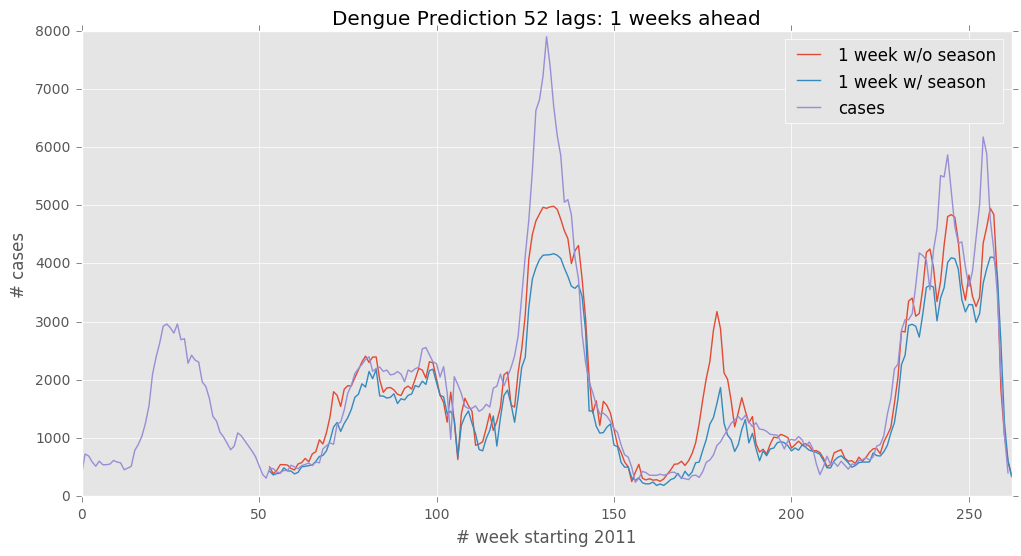

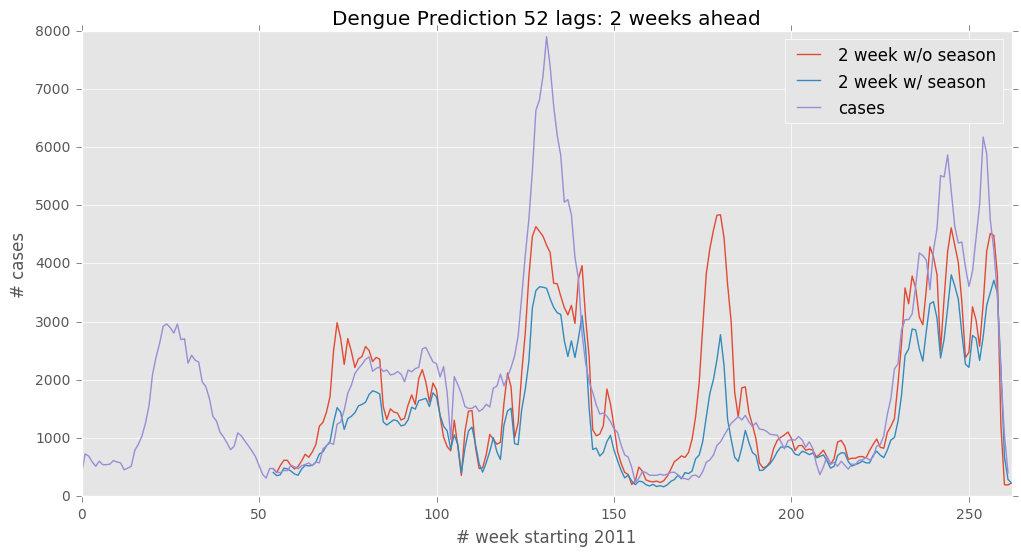

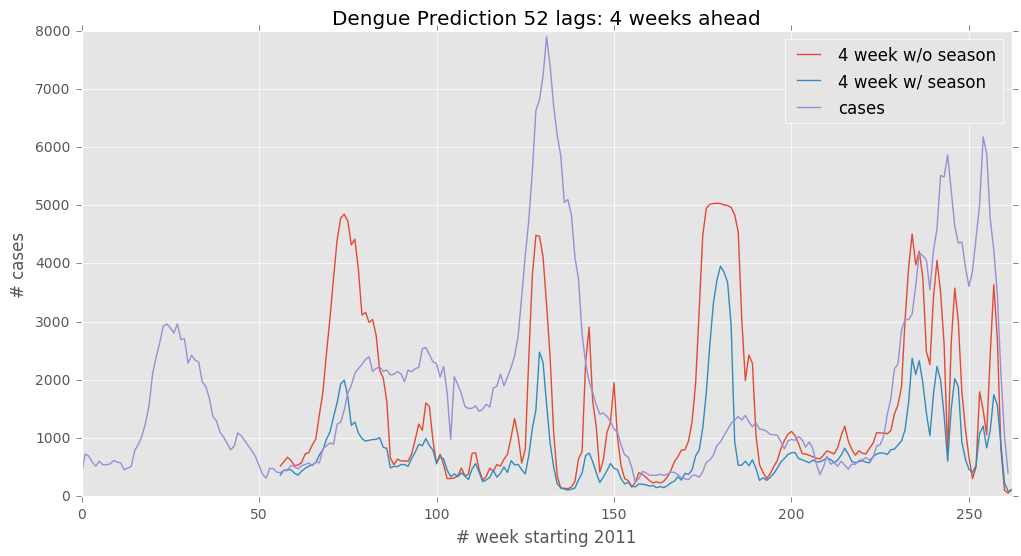

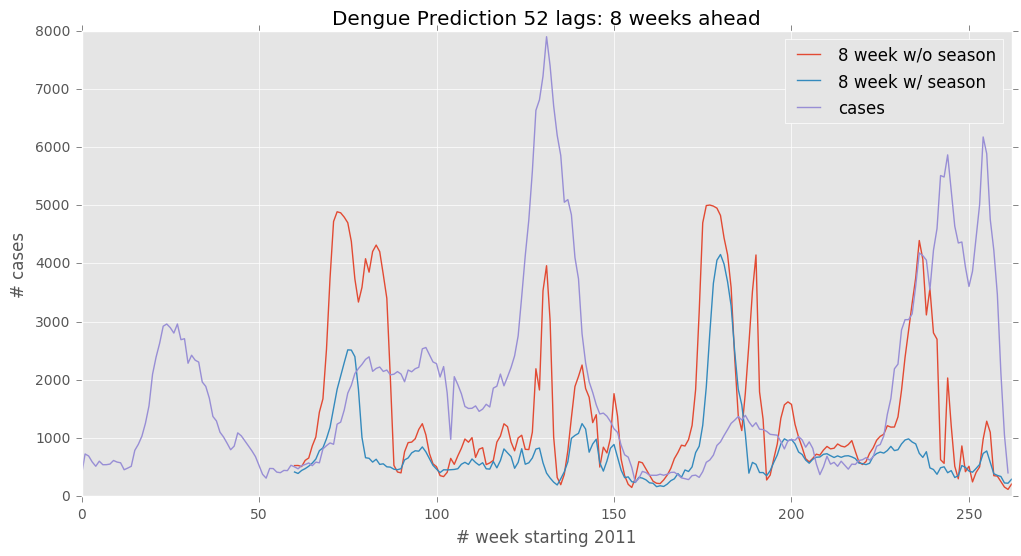

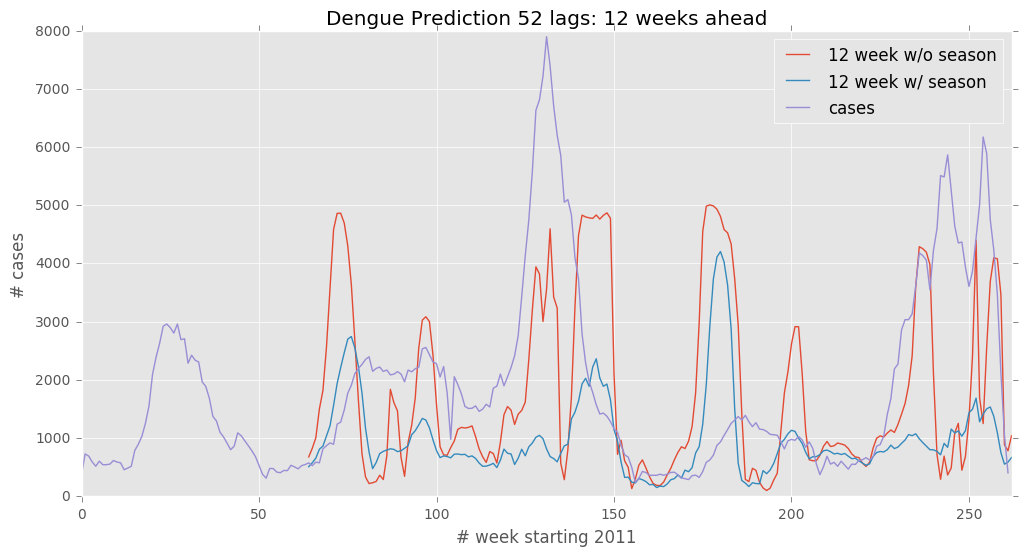

In [86]:
for week_ahead in nweek_to_predict:
    plt.figure(figsize=(12,6))
    without_season = '%d week w/o season'%week_ahead
    with_season = '%d week w/ season'%week_ahead
    all_predictions_df[without_season].plot()
    all_predictions_df[with_season].plot()
    plt.plot([i for i in range(len(test))],test)
    plt.xlabel("# week starting 2011")
    plt.ylabel("# cases")
    plt.legend()
    title = 'Dengue Prediction 52 lags: %d weeks ahead'%week_ahead
    plt.title(title)

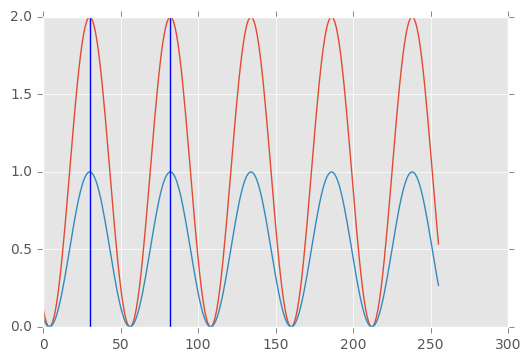

In [226]:
def trial01(wk_no):
    period = np.math.pi / 26
    inside = (period*wk_no) - ((30*np.math.pi / 26.))
    return np.math.cos(inside) + 1

def trial02(wk_no):
    period = np.math.pi / 52
    inside = (period*wk_no) - (30*np.math.pi / 52.)
    cosine_sq = np.math.cos(inside)**2
    return cosine_sq

idx = [i for i in range(128*2)]
idy = [trial01(i) for i in idx]
idyy = [trial02(i) for i in idx]

plt.plot(idx,idy,idx,idyy)
plt.axvline(30)
plt.axvline(82)

In [ ]:
BETAS_SET = lag + 1
ALL_WS = BETAS_SET + 1

def guess(w,x):
    def theta(w,x):
        pad_x = np.concatenate(([1],np.array(x)))
        score = np.dot(w[:-1],pad_x)
        return expit(score)

    return np.log(theta(w,x)+ 1e-5) + w[-1] 

def cost(w):
    ret = 0
    for i in range(len(train)-ALL_WS):
        real_case = np.log(train[i+ALL_WS])
        predicted_case = guess(w,train[i:i+lag])
        ret += (real_case - predicted_case)**2
    return ret/float(len(train))

starter = np.log(3000.)#np.log(7500.)
arr = np.array([0.]*BETAS_SET)
arr = np.append(arr,starter)
w = minimize(cost,arr).x